#**Working with the Functional vs. Sequential API**

I'm going to load the Boston Housing dataset again, just for demonstration purposes.

In [1]:
from tensorflow.keras.datasets import boston_housing
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

(train_data, train_targets), (test_data, test_targets) = (
    boston_housing.load_data())

57026/57026 [==============================] - 0s 0us/step


#*Simple, Feed-forward Topology*

Recall that we could specify a Sequential model as follows...

In [3]:
# Start the model... note that I can 'name' the model as part of this.
model = keras.Sequential(name="Boston Housing Model")

# Add some layers... I can name those too. 
# The Sequential API approach forces me to full connect everything I add to the last layer of what I've done so far. 
# It only alows a single pipe from input to output, of variable width. 
model.add(layers.Input(13, name="inputs"))
model.add(layers.Dense(8, activation="relu",name="first_hidden"))
model.add(layers.Dense(8, activation="relu",name="second_hidden"))
model.add(layers.Dense(1,name="output"))

# Compile the model.
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])

# Draw a picture of the model... 
#keras.utils.plot_model(model,show_shapes=True)
model.summary()

Model: "Boston Housing Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 first_hidden (Dense)        (None, 8)                 112       
                                                                 
 second_hidden (Dense)       (None, 8)                 72        
                                                                 
 output (Dense)              (None, 1)                 9         
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


We can specify the exact same model using the Functional API, as follows... 

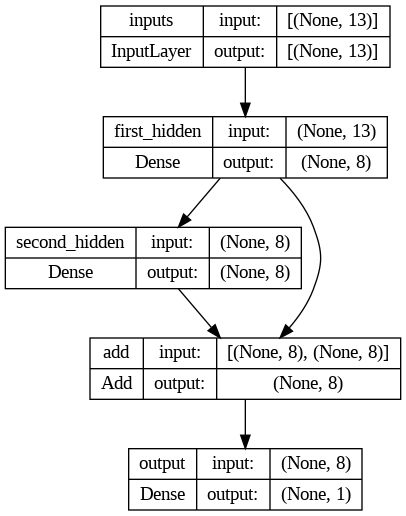

In [6]:
# I define my input layer, with shape = number of predictors in the data.
inputs = keras.layers.Input(shape=(train_data.shape[1],),name="inputs")

# I then define the first hidden layer, which is connected to the prior input layer.
# I can connect the input layer to this, and I could connect some other layer... 
first_hidden = keras.layers.Dense(8, activation="relu", name="first_hidden")(inputs)
second_hidden = keras.layers.Dense(8, activation="relu", name="second_hidden")(first_hidden)

concatenate = keras.layers.Add()([first_hidden,second_hidden])

# I then define my output layer, which connects to the hidden layer.
output = keras.layers.Dense(1, name="output")(concatenate)

# Finally, I feed the defined layer structure into a Keras model. 
model = keras.Model(name="Bouston Housing",inputs=[inputs],outputs=[output])

# Draw a picture of the model. 
keras.utils.plot_model(model,show_shapes=True)

#*More Complex Toplogy with Functional API*

Now we can use the functional API to make almost any topology we want, mixing and matching layers, and creating whatever branching logic we like...

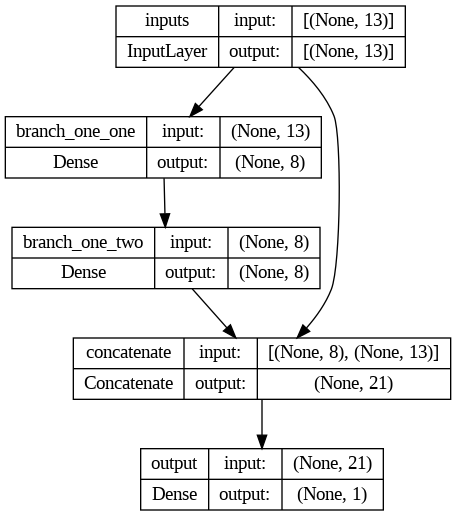

In [ ]:
# I define my input layer, with shape = number of predictors in the data.
inputs_1 = keras.layers.Input(shape=(train_data.shape[1],),name="inputs")

# I then define the first hidden layer, which is connected to the prior input layer.
# I can connect the input layer to this, and I could connect some other layer... 
one_one_hidden = keras.layers.Dense(8, activation="relu", name="branch_one_one")(inputs)
one_two_hidden = keras.layers.Dense(8, activation="relu", name="branch_one_two")(one_one_hidden)

# I then define my output layer, which takes input from the prior set of hidden layers, in addition to taking the inputs directly as well.
# This is what's known as a residual connection.
merge = keras.layers.Concatenate()([one_two_hidden,inputs])
output = keras.layers.Dense(1, name="output")(merge)

# Finally, I feed the defined layer structure into a Keras model. 
model = keras.Model(name="Bouston Housing",inputs=[inputs],outputs=[output])

# Draw a picture of the model. 
keras.utils.plot_model(model,show_shapes=True)

For kicks, let's see how this model performs on the Boston Housing data. First, let's wrap the model build code inside a build function. Note that I'm adding a batch norm layer to whiten the inputs. 

In [ ]:
def build_model(n_predictors=13):
    # I define my input layer, with shape = number of predictors in the data.
    inputs = keras.layers.Input(shape=(n_predictors,),name="inputs")
    norm = keras.layers.BatchNormalization(center=True)(inputs)

    # I then define the first hidden layer, which is connected to the prior input layer.
    # I can connect the input layer to this, and I could connect some other layer... 
    one_one_hidden = keras.layers.Dense(8, activation="relu", name="branch_one_one")(norm)
    one_two_hidden = keras.layers.Dense(8, activation="relu", name="branch_one_two")(one_one_hidden)

    # I then define my output layer, which takes input from the prior set of hidden layers, in addition to taking the inputs directly as well.
    merge = keras.layers.Concatenate()([one_two_hidden,norm])
    output = keras.layers.Dense(1, name="output")(merge)

    # Finally, I feed the defined layer structure into a Keras model. 
    model = keras.Model(inputs=[inputs],outputs=[output])

    model.compile(optimizer="rmsprop",loss="mae",metrics=['mae'])
    return model

And, let's do the same cross-validation we did last time...

In [ ]:
k = 3 
num_val_samples = len(train_data) // k # floor division (i.e., round down to nearest integer.)
num_epochs = 150
batch_size = 25
all_mae_histories = []  

print("In total, we have",len(train_data),"training observations.")
print("With a k of",k,"we have",num_val_samples,"observations per fold.\n")

for i in range(k): # the folds are going to be indexed 0 through 3 if k = 4
    print("Processing fold #:",i)
    # if I slice past the end of the array, it just gives me what it can find! No errors.
    # This is important here, because the last fold won't produce an error, despite our slice going well beyond the end of the array.
    print("Validation data includes observations",i*num_val_samples,"through",(i+1)*num_val_samples) # minus 1 because a slice is up to and not including the second index.
    val_data = train_data[i * num_val_samples: (i + 1) * num_val_samples] 
    val_targets = train_targets[i * num_val_samples: (i + 1) * num_val_samples]
    print("Training data includes observations 0 through",i*num_val_samples,"joined with observations",(i+1)*num_val_samples,"through the final observation.\n")
    partial_train_data = np.concatenate(
        [train_data[:i * num_val_samples],
         train_data[(i + 1) * num_val_samples:]],
        axis=0)
    partial_train_targets = np.concatenate(
        [train_targets[:i * num_val_samples],
         train_targets[(i + 1) * num_val_samples:]],
        axis=0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data=(val_data, val_targets),
                        epochs=num_epochs, batch_size=batch_size, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In total, we have 404 training observations.
With a k of 3 we have 134 observations per fold.

Processing fold #: 0
Validation data includes observations 0 through 134
Training data includes observations 0 through 0 joined with observations 134 through the final observation.

Processing fold #: 1
Validation data includes observations 134 through 268
Training data includes observations 0 through 134 joined with observations 268 through the final observation.

Processing fold #: 2
Validation data includes observations 268 through 402
Training data includes observations 0 through 268 joined with observations 402 through the final observation.



And, finally, plot the loss over the training process... 

3.0622569719950357


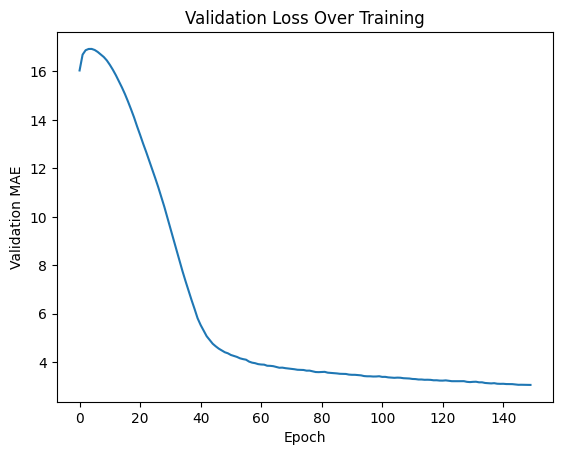

In [ ]:
import matplotlib.pyplot as plt

# The final cross-fold average MAE in our training was about $3,000.
print(average_mae_history[-1]) # index of -1 means final value in the list.

plt.plot(average_mae_history)
plt.ylabel('Validation MAE')
plt.xlabel('Epoch')
plt.title('Validation Loss Over Training')
plt.show()